In [10]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv

In [3]:
# importing all following data and putting in a graph
pkl_file = open('Unfollower/15weeks_friend_dict.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()

week = 0
for key, values in mydict2.items():
    if len(values[week]) == 0:
        mydict2[key] = []
        continue
    new = values[week][1]
    mydict2[key] = new

# mydict2 has format:
# user_id: [following_user_id1, following_user_id2...]

In [4]:
# forrest fire sampling implementation and use 
def forest_fire_sampling(graph_dict, initial_burn_probability, secondary_burn_probability, max_samples=None):
    # Choose a random start node
    random.seed(947)
    start_node = random.choice(list(graph_dict.keys()))
    
    # Force starting node to have at least 100 friends 
    if len(graph_dict[start_node]) < 100:
        start_node = random.choice(list(graph_dict.keys()))
    sampled_nodes = set([start_node])
    burning_nodes = set([start_node])
    
    while burning_nodes:
        new_burning_nodes = set()
        for node in burning_nodes:
            # For each neighbor, decide if it catches fire based on the burn probability
            for neighbor in graph_dict[node]:
                if neighbor not in sampled_nodes:
                    if random.random() < (initial_burn_probability if node == start_node else secondary_burn_probability):
                        new_burning_nodes.add(neighbor)
                        sampled_nodes.add(neighbor)
                        if max_samples and len(sampled_nodes) >= max_samples:
                            return sampled_nodes
        burning_nodes = new_burning_nodes

    return sampled_nodes

# sampling has undeterministic results where sample may have few nodes or many nodes depending on whether random starting node has many or few neighbors. We may want to force the starting node to have more than 10 friends. 

sample = forest_fire_sampling(mydict2, 0.2, 0.1, max_samples=1000)
shortened_dict = defaultdict(list)
print(len(mydict2))
for k in mydict2:
    if k in sample: 
        for v in mydict2[k]:
            if v in sample: 
                shortened_dict[k].append(v)

print(len(shortened_dict))

118640
968


In [6]:
# Creating sample graph and drawing it 
subset_followers_graph = nx.DiGraph()
for k, v in shortened_dict.items():
    for neighbor in v:
        subset_followers_graph.add_edge(k, neighbor)

print(subset_followers_graph.number_of_nodes())

1000


In [5]:
# Draw the graph node
nx.draw(subset_followers_graph, with_labels=False, node_size=20, node_color=(0.392, 0.584, 0.929, 0.5))

# Display the graph
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


KeyboardInterrupt: 

In [7]:
removed_edges_graph = subset_followers_graph.copy()
print("edges before removal:",removed_edges_graph.number_of_edges())
def remove_edges(G, k):
    # Calculate the number of edges to remove (10% of total edges)
    num_edges_to_remove = int(k * G.number_of_edges())
    
    # Get the list of all edges in the graph
    all_edges = list(G.edges())
    random.seed(947)
    # Randomly select edges to remove
    removed_edges = random.sample(all_edges, num_edges_to_remove)
    
    # Remove the selected edges from the graph
    G.remove_edges_from(removed_edges)
    
    return set(removed_edges)

removed_edges = remove_edges(removed_edges_graph,0.1)
removed_nodes_set = set()
for edge in removed_edges:
    removed_nodes_set.add(edge[0])
print("edges after removal:", removed_edges_graph.number_of_edges())
print(f"density: {nx.density(removed_edges_graph)}")

edges before removal: 27424
edges after removal: 24682
density: 0.024706706706706705


In [30]:
edge_list = list(subset_followers_graph.edges)

# Simple GNN, might be better to test with multiple convolutional layers
class GNN(nn.Module):
    def __init__(self, num_nodes, embedding_dim=16):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_nodes, embedding_dim)
        self.conv2 = GCNConv(embedding_dim, 1)  # Output 1 for edge prediction

    def forward(self, edge_index):
        x = torch.ones((num_nodes, 1), dtype=torch.float32)  # Dummy node features
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x.squeeze(dim=1)

# Split the edge list into training and test sets
train_edge_list, test_edge_list = train_test_split(edge_list, test_size=0.15, random_state=42)
print(train_edge_list)
all_nodes = set(node for edge in edge_list for node in edge)
num_nodes = len(all_nodes)

model = GNN(num_nodes)

# The optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# List of nodes 
node_list = list(removed_edges_graph.nodes())

# Create a dictionary that maps node to index
node_to_i = {node: index for index, node in enumerate(node_list)}

# Training
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Adjacency matrix
    adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
    for edge in train_edge_list:
        adjacency_matrix[node_to_i[edge[0]], node_to_i[edge[1]]] = 1.0
    
    print(adjacency_matrix.size())
    predictions = model(adjacency_matrix)

    targets = torch.zeros_like(predictions)
    for edge in train_edge_list:
        targets[edge[0], edge[1]] = 1.0

    loss = criterion(predictions, targets)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

model.eval()

# Adjacency matrix for the entire graph
adjacency_matrix_full = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
for edge in edge_list:
    adjacency_matrix_full[edge[0], edge[1]] = 1.0

# Predictions for the entire graph
predictions_full = model(adjacency_matrix_full)

# Evaluate on the test set
test_predictions = torch.zeros_like(predictions_full)
for edge in test_edge_list:
    test_predictions[edge[0], edge[1]] = 1.0

threshold = 0.5
binary_predictions = (predictions_full > threshold).int()

# Calculate accuracy on the test set
correct_predictions = (binary_predictions == test_predictions).sum().item()
total_predictions = test_predictions.sum().item()
accuracy = correct_predictions / total_predictions

print(f"Test Accuracy: {accuracy:.4f}")

[('43821108', '1172185038'), ('14381152', '3716745856'), ('370397837', '89809372'), ('43652382', '36653441'), ('65017689', '898565245484105732'), ('14408924', '17839109'), ('495430242', '14771839'), ('211137580', '14103014'), ('896384784', '15587326'), ('6270652', '243683803'), ('2295554268', '870606756'), ('1114836386', '41860681'), ('128721691', '7622782'), ('231845623', '111193493'), ('9047952', '10239'), ('796803144642535424', '14103014'), ('585640407', '2260650739'), ('11493602', '44195788'), ('374160268', '14910772'), ('44690011', '17275280'), ('825790369476517893', '1616352942'), ('3237721718', '289158382'), ('495430242', '2347122642'), ('3237721718', '14408924'), ('402143587', '30142130'), ('3253804451', '236796085'), ('326295039', '337709874'), ('10296802', '1387433462'), ('2233489694', '158477225'), ('614440298', '352013269'), ('16389705', '3002592675'), ('25263396', '92096034'), ('5626', '3392755149'), ('14704253', '58631564'), ('14070439', '352013269'), ('881386074', '46276

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1000 but got size 2 for tensor number 1 in the list.

In [8]:
def jaccard_prediction(G, k):
    predictions = {}
    for node1 in removed_nodes_set:
        node1_friends = set(G.neighbors(node1))
        scores = []
        for node2 in list(G.nodes()):
            if node1==node2: continue
            if G.has_edge(node1, node2): continue
            node2_friends = set(G.neighbors(node2))
            total_friends = node1_friends.union(node2_friends)
            numerator = sorted(w for w in node1_friends if w in node2_friends)
            if len(total_friends)==0: score=0
            else: score = len(numerator)/len(total_friends)
            scores.append([node2, score])
        
        predicted_links = list(filter(lambda x: x[1] > k, scores))
        if len(predicted_links)>0:
            predictions[node1] = predicted_links
    
    predicted_edges = set()
    for node1,scores in predictions.items():
        for node2 in scores:
            predicted_edges.add((node1, node2[0]))
    return predicted_edges

In [9]:
def preferential_attachment_prediction(G, k):
    predictions = {}
    for node1 in removed_nodes_set:
        scores = []
        for node2 in list(G.nodes()):
            if node1==node2: continue
            if G.has_edge(node1, node2): continue
            
            score = G.degree(node1) * G.degree(node2)
            scores.append([node2, score])
        
        predicted_links = list(filter(lambda x: x[1] > k, scores))
        if len(predicted_links)>0:
            predictions[node1] = predicted_links
            
    predicted_edges = set()
    for node1,scores in predictions.items():
        for node2 in scores:
            predicted_edges.add((node1, node2[0]))
    return predicted_edges


In [15]:
def assess_accuracy(predicted_edges, actual_edges):
    actual_edge_set = set(actual_edges)
    predicted_edge_set = set(predicted_edges)
    
    # Calculate True Positive, False Positive, True Negative, False Negative
    true_positive = len(actual_edge_set.intersection(predicted_edge_set))
    false_positive = len(predicted_edge_set - actual_edge_set)
    false_negative = len(actual_edge_set - predicted_edge_set)
    
    # Calculate precision, recall, and f1 score
    
    # accuracy of positive predictions - if we predicted edge, is there actually edge?
    precision = true_positive / (true_positive + false_positive)
    
    # if there is edge, % of time we predict edge accurately?
    recall = true_positive / (true_positive + false_negative)
    
    # means of balancing
    if precision == 0 and recall == 0: f1_score = 0
    else: f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Print the results
    print(f"Precision: {precision:.2f}", end=" ")
    print(f"Recall: {recall:.2f}", end = " ")
    print(f"F1 Score: {f1_score:.2f}")

In [18]:
print("Jaccard")
k = 0
while k < 1:
    jaccard_coefficient_graph_copy = removed_edges_graph.copy()
    jaccard_predicted_edges = jaccard_prediction(jaccard_coefficient_graph_copy, k)
    if len(jaccard_predicted_edges) == 0:
        break
    print(f"k={k}:")
    assess_accuracy(jaccard_predicted_edges, removed_edges)
    k += 0.1

print("Preferential")
k = 10000
while k < 100000:
    preferential_graph_copy = removed_edges_graph.copy()
    preferential_predicted_edges = preferential_attachment_prediction(preferential_graph_copy, k)
    if len(preferential_predicted_edges) == 0:
        break
    print(f"k={k}:")
    assess_accuracy(preferential_predicted_edges, removed_edges)
    k += 10000

Jaccard
k=0:
Precision: 0.01 Recall: 0.89 F1 Score: 0.02
k=0.1:
Precision: 0.04 Recall: 0.36 F1 Score: 0.07
k=0.2:
Precision: 0.09 Recall: 0.08 F1 Score: 0.08
k=0.30000000000000004:
Precision: 0.18 Recall: 0.02 F1 Score: 0.03
k=0.4:
Precision: 0.29 Recall: 0.00 F1 Score: 0.01
k=0.5:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.6:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.7:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.7999999999999999:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.8999999999999999:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
k=0.9999999999999999:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
Preferential
k=10000:
Precision: 0.02 Recall: 0.23 F1 Score: 0.04
k=20000:
Precision: 0.04 Recall: 0.07 F1 Score: 0.05
k=30000:
Precision: 0.06 Recall: 0.02 F1 Score: 0.03
k=40000:
Precision: 0.08 Recall: 0.01 F1 Score: 0.01
k=50000:
Precision: 0.10 Recall: 0.00 F1 Score: 0.00
k=60000:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00


In [20]:
# Get adjacency matrix
node_list = list(removed_edges_graph.nodes())

# Create a dictionary that maps node to index
node_to_index = {node: index for index, node in enumerate(node_list)}

A_sgd_factorize = nx.to_numpy_array(removed_edges_graph, nodelist=node_list)

def sgd_factorize(A, K, iterations=1000000, learning_rate=0.01, lambda_reg=0.02):
    """
    Factorizes the matrix A into the product of two matrices U and V using SGD.
    A: Adjacency matrix
    K: Number of latent features
    iterations: Number of iterations for SGD
    learning_rate: Learning rate for SGD updates
    lambda_reg: Regularization parameter
    """
    N, M = A.shape
    U = np.random.rand(N, K)
    V = np.random.rand(M, K)
    losses = []  # to store the loss values

    # SGD iterations
    for it in range(iterations):
        # Randomly select a non-zero element from A
        i, j = np.random.choice(N), np.random.choice(M)
        if A[i, j] > 0:
            # Compute prediction and error
            pred = np.dot(U[i, :], V[j, :].T)
            e = A[i, j] - pred

            # Update U and V
            U[i, :] += learning_rate * (e * V[j, :] - lambda_reg * U[i, :])
            V[j, :] += learning_rate * (e * U[i, :] - lambda_reg * V[j, :])
            
            # Compute the loss for this iteration (simplified version)
            loss = e**2
            losses.append(loss)
    
    return U, V, losses

K = 10  # example choice, this could be tuned
U, V, losses = sgd_factorize(A_sgd_factorize, K, learning_rate=0.1)

reconstructed_A_sgd_factorize = np.dot(U, V.T)

578246
2742
Precision: 0.00 Recall: 0.68 F1 Score: 0.01


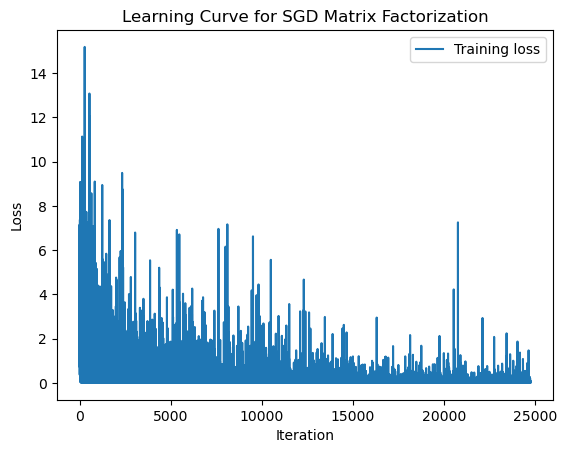

In [27]:
# Assuming U and V are the factorized matrices and you've reconstructed A as reconstructed_A
threshold = 0.9 #Example threshold for determining an edge
sgd_factorize_predicted_edges = set()

for i in range(reconstructed_A_sgd_factorize.shape[0]):
    # only give link predictions for removed nodes set
    if node_list[i] not in removed_nodes_set:
        continue
    for j in range(reconstructed_A_sgd_factorize.shape[1]):
        if i != j and reconstructed_A_sgd_factorize[i, j] >= threshold and A_sgd_factorize[i][j] != 1:   # Assuming no self-loops
            node_i = node_list[i]
            node_j = node_list[j]
            sgd_factorize_predicted_edges.add((node_i, node_j))

print(len(sgd_factorize_predicted_edges))
print(len(removed_edges))
assess_accuracy(sgd_factorize_predicted_edges, removed_edges)

In [ ]:
# Plot the learning curve
plt.plot(losses, label='Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Learning Curve for SGD Matrix Factorization')
plt.legend()
plt.show()